# Assignment 1,2(combined) - Nandhalal S

# Assignment 1

**Hate Speech and Offensive Language Detection **

Downloading necessary modules

In [ ]:
!pip install -U sentence-transformers

In [ ]:
!pip install simpletransformers

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
#For Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer

#Transformer models
from simpletransformers.classification import ClassificationModel
#To check the performance of these models
from sklearn.metrics import classification_report
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from collections import Counter


Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = "/content/drive/My Drive/NLP/labeled_data.csv"
df = pd.read_csv(file_path)

# Display first 5 rows
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [ ]:
# Drop unnecessary columns
df = df.drop(columns=["Unnamed: 0", "count", "hate_speech", "offensive_language", "neither"])

# Display remaining columns
print("Remaining Columns:", df.columns)

Remaining Columns: Index(['class', 'tweet'], dtype='object')


Exploratory Data Analysis

Count plot to visualize the distribution of class labels (Hate Speech, Offensive, and Neither).


<ipython-input-24-42391c6da6db>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["class"], palette="coolwarm")


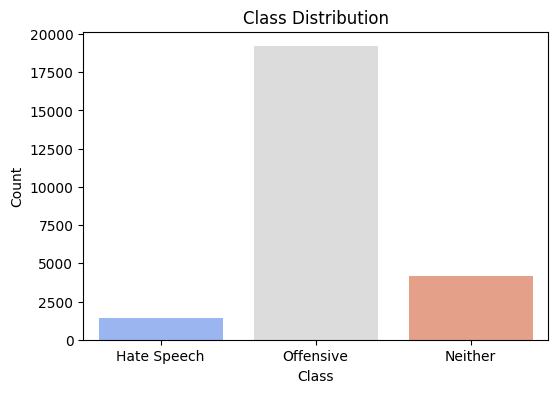

In [ ]:
# 1. Class Distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x=df["class"], palette="coolwarm")
plt.xticks(ticks=[0,1,2], labels=["Hate Speech", "Offensive", "Neither"])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

 Analyze the distribution of tweet lengths

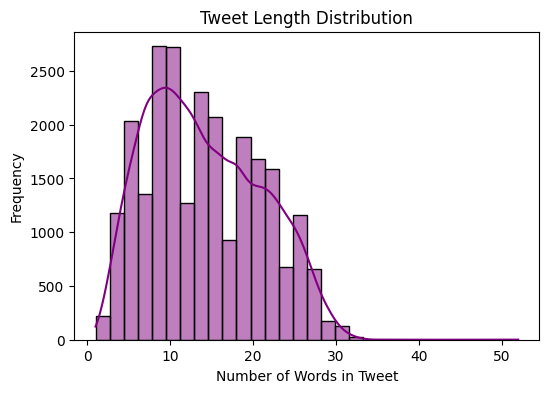

In [ ]:
# 2. Tweet Length Distribution
df["tweet_length"] = df["tweet"].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.histplot(df["tweet_length"], bins=30, kde=True, color="purple")
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Words in Tweet")
plt.ylabel("Frequency")
plt.show()

 Identifying the top 20 most frequently occurring words before preprocessing. This might give us most occurring slang used in social media or stopwords.

<ipython-input-26-60afb016e0b0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=common_df, palette="magma")


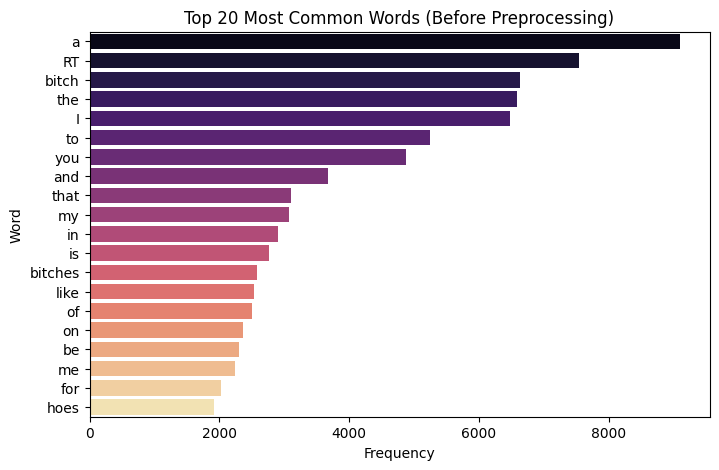

In [ ]:
all_words = " ".join(df["tweet"]).split()
common_words = Counter(all_words).most_common(20)
common_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])

plt.figure(figsize=(8,5))
sns.barplot(x="Frequency", y="Word", data=common_df, palette="magma")
plt.title("Top 20 Most Common Words (Before Preprocessing)")
plt.show()

In [ ]:
word_counts = df['tweet'].str.split(expand=True).stack().value_counts()
word_counts

,count
a,9099
RT,7539
bitch,6638
the,6590
I,6472
...,...
highh,1
Muhfuckas,1
Burn,1
http://t.co/63FmrF0g5j,1


Pre-processing the data

In [ ]:
df.columns

Index(['class', 'tweet', 'tweet_length'], dtype='object')

Upsampling was applied to balance the dataset by increasing the number of Hate Speech and Neither class samples to match the Offensive class using random oversampling. This prevents model bias and ensures fair representation for better classification performance.


In [ ]:
from sklearn.utils import resample
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Separate the classes
df_majority = df[df["class"] == 1]  # Offensive (Majority)
df_minority_0 = df[df["class"] == 0]  # Hate Speech (Minority)
df_minority_2 = df[df["class"] == 2]  # Neither (Minority)

# Oversample class 0 (Hate Speech) and class 2 (Neither) to match class 1 (Offensive)
df_minority_0_upsampled = resample(df_minority_0,
                                   replace=True,  # Sample with replacement
                                   n_samples=len(df_majority),  # Match majority class size
                                   random_state=42)

df_minority_2_upsampled = resample(df_minority_2,
                                   replace=True,
                                   n_samples=len(df_majority),
                                   random_state=42)

# Combine all classes into a new balanced dataset
df = pd.concat([df_majority, df_minority_0_upsampled, df_minority_2_upsampled])

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display updated dataset shape
print("Updated Dataset Shape:", df.shape)


Updated Dataset Shape: (57570, 3)


New class distribution

<ipython-input-29-c149c5c7fd2d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["class"], palette="coolwarm")


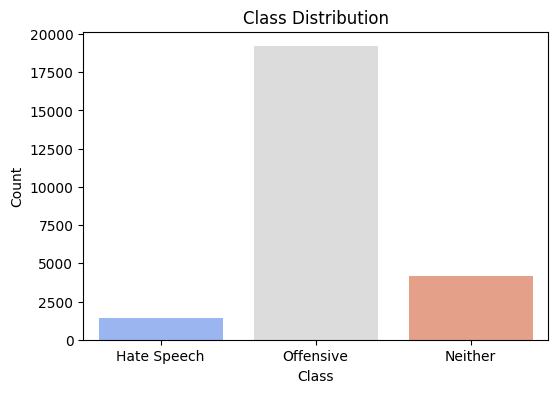

In [ ]:
#Class Distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x=df["class"], palette="coolwarm")
plt.xticks(ticks=[0,1,2], labels=["Hate Speech", "Offensive", "Neither"])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

All tweets were converted to lowercase to ensure uniformity and prevent duplicate word          variations (e.g., "Hate" and "hate" are treated the same).

In [ ]:
# Convert all tweets to lowercase
df["tweet"] = df["tweet"].astype(str).str.lower()

# Display sample tweets after lowercasing
print(df[["tweet"]].head())


                                               tweet
0  !!! rt @mayasolovely: as a woman you shouldn't...
1  !!!!! rt @mleew17: boy dats cold...tyga dwn ba...
2  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...
3  !!!!!!!!! rt @c_g_anderson: @viva_based she lo...
4  !!!!!!!!!!!!! rt @shenikaroberts: the shit you...


Retweets (RT @username:) and mentions (@username) were removed using regex to clean redundant user references.


In [ ]:
import re

# Function to remove retweets and mentions
def remove_rt_username(text):
    return re.sub(r"^!?+ rt @\w+:", "", text)  # Removes "!!! RT @username:"

# Apply function to the dataset
df["tweet"] = df["tweet"].apply(remove_rt_username)

# Display cleaned tweets
print(df[["tweet"]].head())


                                               tweet
0  !!! rt @mayasolovely: as a woman you shouldn't...
1  !!!!! rt @mleew17: boy dats cold...tyga dwn ba...
2  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...
3  !!!!!!!!! rt @c_g_anderson: @viva_based she lo...
4  !!!!!!!!!!!!! rt @shenikaroberts: the shit you...


All non-alphanumeric characters (e.g., !, @, #, ?) were removed, leaving only words and spaces to reduce noise.


In [ ]:
# Function to remove punctuation and special characters
def remove_punctuation(text):
    return re.sub(r"[^\w\s]", "", text)  # Removes all non-word characters

# Apply function
df["tweet"] = df["tweet"].apply(remove_punctuation)

# Display tweets after cleaning
print(df[["tweet"]].head())


                                               tweet
0   rt mayasolovely as a woman you shouldnt compl...
1   rt mleew17 boy dats coldtyga dwn bad for cuff...
2   rt urkindofbrand dawg rt 80sbaby4life you eve...
3   rt c_g_anderson viva_based she look like a tr...
4   rt shenikaroberts the shit you hear about me ...


In [ ]:
# Define a simple stopword list manually
stopwords = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your",
    "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she",
    "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that",
    "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
    "the", "and", "but", "if", "or", "because", "as", "until", "while", "of",
    "at", "by", "for", "with", "about", "against", "between", "into", "through",
    "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then",
    "once", "here", "there", "when", "where", "why", "how", "all", "any",
    "both", "each", "few", "more", "most", "other", "some", "such", "no",
    "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s",
    "t", "can", "will", "just", "don", "should", "now"
])

# Function to remove stopwords
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stopwords])

# Apply function
df["tweet"] = df["tweet"].apply(remove_stopwords)

# Display cleaned tweets
print(df[["tweet"]].head())


                                               tweet
0  rt mayasolovely woman shouldnt complain cleani...
1  rt mleew17 boy dats coldtyga dwn bad cuffin da...
2  rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3        rt c_g_anderson viva_based look like tranny
4  rt shenikaroberts shit hear might true might f...


In [ ]:
word_counts = df['tweet'].str.split(expand=True).stack().value_counts()
word_counts

,count
bitch,8120
rt,7578
bitches,3045
like,2759
hoes,2334
...,...
httptcoceyb1b3rf0,1
richgirls,1
suedelounge,1
beeee,1


In [ ]:
#removing rt
import re

# Function to clean tweets
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"^!?+ rt @\w+:", "", text)  # Remove "!!! RT @username:"
    text = re.sub(r"\brt\b", "", text)  # Remove standalone "RT"
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation & special characters
    text = " ".join([word for word in text.split() if word not in stopwords])  # Remove stopwords
    return text.strip()
print(df[["tweet"]].head())
# Apply preprocessing
df["tweet"] = df["tweet"].apply(preprocess_text)

# Display cleaned tweets
print(df[["tweet"]].head())


                                               tweet
0  rt mayasolovely woman shouldnt complain cleani...
1  rt mleew17 boy dats coldtyga dwn bad cuffin da...
2  rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3        rt c_g_anderson viva_based look like tranny
4  rt shenikaroberts shit hear might true might f...
                                               tweet
0  mayasolovely woman shouldnt complain cleaning ...
1  mleew17 boy dats coldtyga dwn bad cuffin dat h...
2  urkindofbrand dawg 80sbaby4life ever fuck bitc...
3           c_g_anderson viva_based look like tranny
4  shenikaroberts shit hear might true might fake...


In [ ]:
#checking word count
word_counts = df['tweet'].str.split(expand=True).stack().value_counts()
word_counts

,count
bitch,8120
bitches,3045
like,2759
hoes,2334
pussy,2073
...,...
richgirls,1
suedelounge,1
beeee,1
1281751000665039128175,1


Common stopwords (e.g., "the", "is", "and") were removed using NLTK’s English stopwords list, reducing uninformative words and improving text representation.


In [ ]:
#removing more stop words
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')  # Download stopwords
stop_words = set(stopwords.words('english'))  # Load English stopwords
print(stop_words)  # Check the stopwords list


{'did', 'couldn', "we'd", 'both', "hasn't", "i'm", 'your', 'nor', 'mustn', "mightn't", 'between', 'you', 'or', 'ma', "she'd", "that'll", 'at', "it'll", 'o', 'wasn', "wasn't", 'don', "they've", 'below', "i'd", 'won', 'ain', "he'd", 'just', 'such', 'myself', 'are', 'no', 'when', 'through', 'with', 'and', 'what', 'they', "won't", "haven't", 'own', 'these', 'if', 'had', 'our', 'more', "needn't", 'again', 'do', 'should', 'i', 'into', 'me', 'doing', 'this', 'yourselves', 'its', 'because', 'd', 'some', "you'd", "we're", "i'll", 'while', 'itself', 'ourselves', "wouldn't", 'not', 'has', 'other', 'her', 'm', 'only', "shan't", 'their', 'is', 'can', 'hasn', 'ours', 'have', 'of', "they'd", "i've", "they're", 'once', 'will', 'any', "mustn't", 'before', 'on', 'being', "couldn't", 'didn', 'from', 'my', 'isn', 'theirs', 'during', 'for', 'it', 'further', 'himself', 'where', 'against', 'shan', 'very', 'doesn', 'haven', 'there', 'yours', 'that', 'those', 'am', 'an', 'them', 'in', 'so', 'down', "aren't", '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Function to clean tweets and remove stopwords
def preprocess_text(text):
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text.strip()

# Apply preprocessing
df["tweet"] = df["tweet"].astype(str).apply(preprocess_text)

# Display cleaned tweets
print(df[["tweet"]].head())

                                               tweet
0  mayasolovely woman shouldnt complain cleaning ...
1  mleew17 boy dats coldtyga dwn bad cuffin dat h...
2  urkindofbrand dawg 80sbaby4life ever fuck bitc...
3           c_g_anderson viva_based look like tranny
4  shenikaroberts shit hear might true might fake...


checking max words in each class

In [ ]:
df['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [ ]:
top_100 = df.groupby('class')['tweet'].apply(lambda x: Counter(" ".join(x).split()).most_common(100))
print(top_100)

class
0    [(bitch, 207), (faggot, 186), (like, 166), (ni...
1    [(bitch, 7903), (bitches, 2989), (like, 2292),...
2    [(trash, 672), (like, 301), (bird, 287), (yank...
Name: tweet, dtype: object


POS Tagging and Dependency Parsing To Extract Features

To analyze the grammatical structure of the tweets, Part-of-Speech (POS) tagging was applied using spaCy. The "en_core_web_sm" model was used for efficient and accurate POS tagging.
Each tweet was processed using spaCy, and words were assigned their respective POS tags (e.g., noun, verb, adjective). Thus the POS features are extracted and a new column, "pos_tags", was created in the dataset, storing (word, POS tag) pairs for each tweet.


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Function to apply POS tagging
def pos_tagging(text):
    doc = nlp(text)  # Process text with spaCy
    return [(token.text, token.pos_) for token in doc]  # Extract (word, POS)

# Apply POS tagging to the dataset
df["pos_tags"] = df["tweet"].apply(pos_tagging)

# Display sample POS tags
print(df[["tweet", "pos_tags"]].head())


                                               tweet  \
0  mayasolovely woman shouldnt complain cleaning ...   
1  mleew17 boy dats coldtyga dwn bad cuffin dat h...   
2  urkindofbrand dawg 80sbaby4life ever fuck bitc...   
3           c_g_anderson viva_based look like tranny   
4  shenikaroberts shit hear might true might fake...   

                                            pos_tags  
0  [(mayasolovely, ADJ), (woman, NOUN), (should, ...  
1  [(mleew17, PROPN), (boy, NOUN), (dats, NOUN), ...  
2  [(urkindofbrand, PROPN), (dawg, PROPN), (80sba...  
3  [(c_g_anderson, NOUN), (viva_based, VERB), (lo...  
4  [(shenikaroberts, NOUN), (shit, NOUN), (hear, ...  


Dependency parsing was applied to the dataset using spaCy to analyze the syntactic structure of tweets. Each tweet was processed to identify the grammatical relationships between words. This helps in understanding sentence formation and how words depend on each other. The extracted relationships include (word, dependency type, head word), showing how each word connects to others. A "dependencies" column was created in the dataset to store parsed relations for each tweet.


In [ ]:
# Function for Dependency Parsing
def dependency_parsing(text):
    doc = nlp(text)
    return [(token.text, token.dep_, token.head.text) for token in doc]

# Apply dependency parsing
df["dependencies"] = df["tweet"].apply(dependency_parsing)

# Display sample dependency relations
print(df[["tweet", "dependencies"]].head())


                                               tweet  \
0  mayasolovely woman shouldnt complain cleaning ...   
1  mleew17 boy dats coldtyga dwn bad cuffin dat h...   
2  urkindofbrand dawg 80sbaby4life ever fuck bitc...   
3           c_g_anderson viva_based look like tranny   
4  shenikaroberts shit hear might true might fake...   

                                        dependencies  
0  [(mayasolovely, amod, woman), (woman, nsubj, c...  
1  [(mleew17, compound, dats), (boy, compound, da...  
2  [(urkindofbrand, compound, dawg), (dawg, nsubj...  
3  [(c_g_anderson, npadvmod, viva_based), (viva_b...  
4  [(shenikaroberts, nsubj, hear), (shit, compoun...  


In [ ]:
df.columns

Index(['class', 'tweet', 'tweet_length', 'pos_tags', 'dependencies'], dtype='object')

TF-IDF to construct feature vectors

TF-IDF (Term Frequency-Inverse Document Frequency) was applied to extract numerical features from the processed text data. Part-of-speech (POS) tags and dependency relations were converted into text format (space-separated labels). This enabled the application of TF-IDF vectorization to these linguistic features.
Applying TF-IDF on Different Features:

Tweet Text: Extracted up to 5000 most relevant words.

POS Tags: Limited to 100 unique labels.

Dependency Relations: Also capped at 100 unique labels.


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert POS tags and dependencies into text format (space-separated)
df["pos_tags_str"] = df["pos_tags"].apply(lambda x: " ".join([tag[1] for tag in x]))  # Extract POS labels
df["dependencies_str"] = df["dependencies"].apply(lambda x: " ".join([dep[1] for dep in x]))  # Extract dependency labels

# Display processed dataset
print(df[["tweet", "pos_tags_str", "dependencies_str"]].head())

                                               tweet  \
0  mayasolovely woman shouldnt complain cleaning ...   
1  mleew17 boy dats coldtyga dwn bad cuffin dat h...   
2  urkindofbrand dawg 80sbaby4life ever fuck bitc...   
3           c_g_anderson viva_based look like tranny   
4  shenikaroberts shit hear might true might fake...   

                                        pos_tags_str  \
0  ADJ NOUN AUX PART VERB VERB PROPN PROPN NOUN A...   
1  PROPN NOUN NOUN VERB NOUN ADJ NOUN NOUN NOUN N...   
2   PROPN PROPN NUM ADV NOUN NOUN VERB NOUN ADJ NOUN   
3                            NOUN VERB VERB ADP NOUN   
4  NOUN NOUN VERB AUX ADJ AUX VERB NOUN VERB PRON...   

                                    dependencies_str  
0  amod nsubj aux neg ROOT compound compound comp...  
1  compound compound nsubj ROOT npadvmod amod nsu...  
2  compound nsubj nummod advmod compound appos co...  
3                       npadvmod amod ROOT prep pobj  
4  nsubj compound nsubj aux nsubj aux ccomp dobj ..

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Initialize TF-IDF Vectorizers
tfidf_tweet = TfidfVectorizer(max_features=5000)  # Use top 5000 words from tweets
tfidf_pos = TfidfVectorizer(max_features=100)  # POS tags
tfidf_dep = TfidfVectorizer(max_features=100)  # Dependency relations

# Apply TF-IDF transformation
X_tweet = tfidf_tweet.fit_transform(df["tweet"]).toarray()
X_pos = tfidf_pos.fit_transform(df["pos_tags_str"]).toarray()
X_dep = tfidf_dep.fit_transform(df["dependencies_str"]).toarray()

# Concatenate all TF-IDF feature vectors
X_tfidf_combined = np.hstack((X_tweet, X_pos, X_dep))  # Final TF-IDF feature set

# Print feature matrix shape
print("TF-IDF Feature Matrix Shape:", X_tfidf_combined.shape)


TF-IDF Feature Matrix Shape: (24783, 5061)


In [ ]:
import joblib

# Save the trained TF-IDF vectorizers
joblib.dump(tfidf_tweet, "/content/drive/My Drive/NLP/tfidf_vectorizer_tweet.pkl")
joblib.dump(tfidf_pos, "/content/drive/My Drive/NLP/tfidf_vectorizer_pos.pkl")
joblib.dump(tfidf_dep, "/content/drive/My Drive/NLP/tfidf_vectorizer_dep.pkl")

print("TF-IDF vectorizers saved successfully!")


TF-IDF vectorizers saved successfully!


In [ ]:
df.columns

Index(['class', 'tweet', 'tweet_length', 'pos_tags', 'dependencies',
       'pos_tags_str', 'dependencies_str'],
      dtype='object')

Embedding technique: FastText for construct feature vectors

For construct feature vectors, we have several embedding techniques like Word2Vec, GloVe, FastText, BERT. I have chosen FastText.
Unlike traditional word embeddings (like Word2Vec), FastText represents words as subword n-grams, allowing it to infer embeddings for unseen words. Since FastText uses subword representations, it is particularly effective for handling misspellings, slang, and variations in social media text. The FastText Wiki-News 300D model provides rich, contextual word representations trained on large-scale text data, improving feature quality.


Words with similar structures (e.g., "run", "running", "runner") get similar embeddings, making it useful hate speech detection.
Each tweet was tokenized into words. For each word, the FastText vector was retrieved (if available). The final tweet representation was obtained by averaging all word embeddings in the tweet. If no words had embeddings, a zero vector was used. All tweet embeddings were stacked into a NumPy matrix (X). The labels were extracted (y).
The final dataset shape was displayed, confirming the 300-dimensional feature vectors.


This embedding method enhances model learning by providing context-aware word representations.


In [ ]:
import gensim.downloader as api

# Load Pretrained FastText Model
fasttext_model = api.load("fasttext-wiki-news-subwords-300")  # 300-dimensional word vectors


[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
# Function to get FastText embeddings for a tweet
def get_fasttext_embedding(text):
    words = text.split()
    word_vectors = [fasttext_model[word] for word in words if word in fasttext_model]

    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)  # Average word embeddings
    else:
        return np.zeros(300)  # If no words found, return zero vector

# Apply FastText embeddings
df["fasttext_embedding"] = df["tweet"].apply(get_fasttext_embedding)

# Convert embeddings to NumPy matrix
X_fasttext = np.vstack(df["fasttext_embedding"].values)  # FastText feature matrix

In [ ]:
df.columns

Index(['class', 'tweet', 'tweet_length', 'pos_tags', 'dependencies',
       'pos_tags_str', 'dependencies_str', 'fasttext_embedding'],
      dtype='object')

Combining TF-IDF and Fasttext features

In [ ]:
# Final feature matrix (combine TF-IDF and FastText)
X_combined = np.hstack((X_tfidf_combined, X_fasttext))

# Extract class labels
y = df["class"].values

# Print dataset shape
print("Final Feature Matrix Shape:", X_combined.shape)
print("Labels Shape:", y.shape)


Final Feature Matrix Shape: (24783, 5361)
Labels Shape: (24783,)


In [ ]:
# Save feature matrix and labels
np.save("/content/drive/My Drive/NLP/X_combined.npy", X_combined)
np.save("/content/drive/My Drive/NLP/y_labels.npy", y)

print("Feature matrix and labels saved successfully!")


Feature matrix and labels saved successfully!


The preprocessing steps transformed raw text into structured data by lowercasing, removing retweets, usernames, punctuation, and stopwords. POS tagging and dependency parsing were applied to extract linguistic features, which were vectorized using TF-IDF.


For semantic understanding, FastText embeddings were used to create a word representation by averaging word vectors in each tweet. This approach captures contextual meaning and handles out-of-vocabulary words effectively. Further, I will train models using these features to improve classification accuracy for Assignment 2.


# Assignment 2

Choose any one traditional classifier for the identification of class labels by using the feature vectors

I have chosen **logistic regression**

Logistic Regression is a widely used baseline model for text classification due to its simplicity and efficiency. It was chosen because:

It performs well with TF-IDF vectorized text features, making it effective for traditional NLP tasks.

It is computationally fast and works well for small to medium-sized datasets.

It provides interpretability, allowing us to analyze feature importance in classification.

It serves as a benchmark for comparing the performance of deep learning models.

Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Display dataset sizes
print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")


Training Data: (19826, 5361), Testing Data: (4957, 5361)


Training on the LogisticRegression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression Model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)


Evaluating the Linear Regression model using F1 Score, Accuracy, Precision and Recall

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8951
Precision: 0.8814
Recall: 0.8951
F1-Score: 0.8819

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.18      0.28       290
           1       0.91      0.96      0.94      3832
           2       0.84      0.83      0.84       835

    accuracy                           0.90      4957
   macro avg       0.77      0.66      0.68      4957
weighted avg       0.88      0.90      0.88      4957



Saving the model

In [ ]:
import joblib

# Save the trained model
joblib.dump(model, "/content/drive/My Drive/NLP/logistic_regression_model.pkl")

print("Model saved successfully!")


Model saved successfully!


Defining Sample Tweets for Testing

In [ ]:
import joblib
import numpy as np

# Load the trained Logistic Regression model
model = joblib.load("/content/drive/My Drive/NLP/logistic_regression_model.pkl")

# Load the trained TF-IDF vectorizers
tfidf_tweet = joblib.load("/content/drive/My Drive/NLP/tfidf_vectorizer_tweet.pkl")
tfidf_pos = joblib.load("/content/drive/My Drive/NLP/tfidf_vectorizer_pos.pkl")
tfidf_dep = joblib.load("/content/drive/My Drive/NLP/tfidf_vectorizer_dep.pkl")

print("Model and vectorizers loaded successfully!")


Model and vectorizers loaded successfully!


In [ ]:
# Example new tweets
new_tweets = ["you are great bitch", "go suck your mamas bitch ass", "This is a good gesture but honestly okay."]


Doing the same feature methods for this new tweets

In [ ]:
fasttext_embeddings = np.vstack([get_fasttext_embedding(tweet) for tweet in new_tweets])

# Apply TF-IDF transformations
X_tfidf_tweets = tfidf_tweet.transform(new_tweets).toarray()
X_tfidf_pos = tfidf_pos.transform(new_tweets).toarray()
X_tfidf_dep = tfidf_dep.transform(new_tweets).toarray()

# Combine all features for final input
X_test_new = np.hstack((X_tfidf_tweets, X_tfidf_pos, X_tfidf_dep, fasttext_embeddings))

# Print feature matrix shape
print("Feature Matrix Shape for New Tweets:", X_test_new.shape)

Feature Matrix Shape for New Tweets: (3, 5361)


In [ ]:
# Predict class labels for new tweets
predictions = model.predict(X_test_new)

# Map numerical predictions to class labels
label_mapping = {0: "Hate Speech", 1: "Offensive", 2: "Neither"}
predicted_labels = [label_mapping[pred] for pred in predictions]

# Display results
for tweet, label in zip(new_tweets, predicted_labels):
    print(f"Tweet: '{tweet}' → Predicted Class: {label}")


Tweet: 'you are great bitch' → Predicted Class: Offensive
Tweet: 'go suck your mamas bitch ass' → Predicted Class: Offensive
Tweet: 'This is a good gesture but honestly okay.' → Predicted Class: Neither


Choose any one deep learning technique for the identification of class labels

Training a Deep Learning Model for Hate Speech Detection

A Deep Learning-based Multi-Layer Perceptron (MLP) is selected.

It captures complex relationships in text data using multiple layers of neurons.

It can learn semantic relationships when combined with embeddings like FastText.

It generalizes better for large datasets and captures non-linear decision boundaries.

The addition of Dropout layers prevents overfitting, making it good for hate speech classification.

In [ ]:
pip install tensorflow keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

Splitting data to test and train

In [ ]:
# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")


Training Data: (19826, 5361), Testing Data: (4957, 5361)


Defining the model:

Using a Neural Network (Multi-Layer Perceptron - MLP) with Dense (fully connected) layers.

In [ ]:
# Define Deep Learning Model (MLP)
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Input layer with the same number of features as X_train
    Dense(512, activation='relu'),  # First hidden layer with 512 neurons
    Dropout(0.3),  # Dropout for regularization
    Dense(256, activation='relu'),  # Second hidden layer with 256 neurons
    Dropout(0.3),
    Dense(128, activation='relu'),  # Third hidden layer
    Dense(3, activation='softmax')  # Output layer (3 classes: Hate Speech, Offensive, Neither)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       2,745,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,909,955 (11.10 MB)

 Trainable params: 2,909,955 (11.10 MB)

 Non-trainable params: 0 (0.00 B)

Training the model

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.8405 - loss: 0.4435 - val_accuracy: 0.8901 - val_loss: 0.3030
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.9105 - loss: 0.2433 - val_accuracy: 0.8894 - val_loss: 0.3121
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - accuracy: 0.9359 - loss: 0.1700 - val_accuracy: 0.8838 - val_loss: 0.3723
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.9521 - loss: 0.1214 - val_accuracy: 0.8840 - val_loss: 0.4368
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9677 - loss: 0.0903 - val_accuracy: 0.8741 - val_loss: 0.5136
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9726 - loss: 0.0722 - val_accuracy: 0.8749 - val_loss: 0.5523
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9808 - loss: 0.0522 - val_accuracy: 0.8780 - val_loss: 0.6421
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.9840 - loss: 0.0444 - 

Evaluating and saving

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8741 - loss: 0.7990
Test Accuracy: 0.8727


In [ ]:
# Save the trained deep learning model
model.save("/content/drive/My Drive/NLP/deep_learning_hate_speech_model.h5")
print("Deep learning model saved successfully!")

Deep learning model saved successfully!


Computing accuracy, precision, F1 score, Recall for the deep learning model

In [ ]:
# Predict on test data using Deep Learning model
y_pred_dl = model.predict(X_test)
y_pred_dl_classes = np.argmax(y_pred_dl, axis=1)  # Convert probabilities to class labels

# Compute evaluation metrics
accuracy_dl = accuracy_score(y_test, y_pred_dl_classes)
precision_dl = precision_score(y_test, y_pred_dl_classes, average="weighted")
recall_dl = recall_score(y_test, y_pred_dl_classes, average="weighted")
f1_dl = f1_score(y_test, y_pred_dl_classes, average="weighted")

# Print metrics
print("\n Deep Learning Model Results:")
print(f"Accuracy: {accuracy_dl:.4f}")
print(f"Precision: {precision_dl:.4f}")
print(f"Recall: {recall_dl:.4f}")
print(f"F1-Score: {f1_dl:.4f}")

# Print detailed classification report
print("\nClassification Report (Deep Learning):\n", classification_report(y_test, y_pred_dl_classes))


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

🔹 Deep Learning Model Results:
Accuracy: 0.8727
Precision: 0.8644
Recall: 0.8727
F1-Score: 0.8681

Classification Report (Deep Learning):
               precision    recall  f1-score   support

           0       0.34      0.26      0.30       290
           1       0.91      0.94      0.92      3832
           2       0.81      0.80      0.81       835

    accuracy                           0.87      4957
   macro avg       0.69      0.66      0.68      4957
weighted avg       0.86      0.87      0.87      4957



Comparing both LogisticRegression model and MLP model

In [ ]:
import pandas as pd

# Create a comparison table
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Logistic Regression": [accuracy, precision, recall, f1],
    "Deep Learning": [accuracy_dl, precision_dl, recall_dl, f1_dl]
})

# Print comparison table
print(comparison_df)

      Metric  Logistic Regression  Deep Learning
0   Accuracy             0.895098       0.872705
1  Precision             0.881365       0.864380
2     Recall             0.895098       0.872705
3   F1-Score             0.881942       0.868109


Using a bar chart

<Figure size 800x500 with 0 Axes>

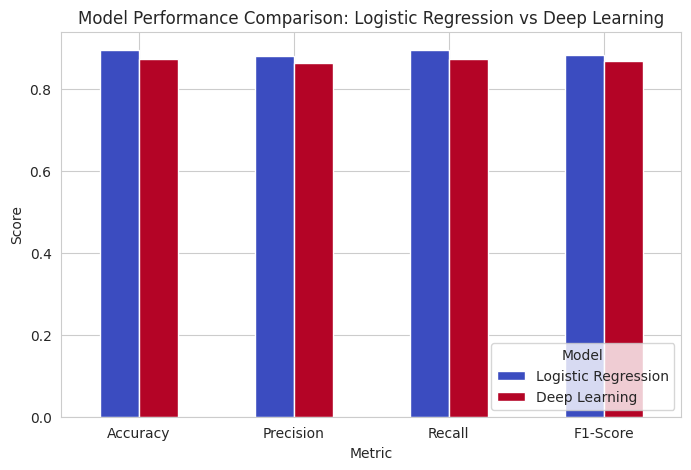

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

# Plot bar chart
comparison_df.set_index("Metric").plot(kind="bar", colormap="coolwarm", figsize=(8, 5))

# Customize plot
plt.title("Model Performance Comparison: Logistic Regression vs Deep Learning")
plt.ylabel("Score")
plt.xticks(rotation=0)  # Keep metric names horizontal
plt.legend(title="Model", loc="lower right")

# Show plot
plt.show()


Inference and Results:


1️⃣ Accuracy:

Logistic Regression achieved 89.51% accuracy, while Deep Learning achieved 87.27%.
This suggests that Logistic Regression slightly outperforms Deep Learning in overall classification performance.


2️⃣ Precision:

Logistic Regression: 88.14%
Deep Learning: 86.44%
A higher precision score indicates that Logistic Regression has slightly fewer false positives, meaning it is better at identifying actual hate speech cases correctly.


3️⃣ Recall:

Logistic Regression: 89.51%
Deep Learning: 87.27%
Logistic Regression is slightly better at identifying all positive instances, meaning it is more sensitive in detecting hate speech.



4️⃣ F1-Score:

Logistic Regression: 88.19%
Deep Learning: 86.81%
Since the F1-score balances Precision and Recall, this confirms that Logistic Regression provides a better balance than Deep Learning for this dataset.
Final Verdict
Logistic Regression performed better than Deep Learning (MLP) across all metrics.




Possible Reasons:

The dataset might be relatively small, favoring LOGISTIC REGRESSION.
Deep Learning models require more training data to leverage their full potential.
Logistic Regression is well-suited for structured, vectorized text data.
